<a href="https://colab.research.google.com/github/OmerNachshon/House-Prices---Advanced-Regression-Techniques/blob/main/House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Omer Nachshon
# 209006535

# TL;DR
Goal: predict sales prices and practice feature engineering 

Approach:

Replace all non numeric values to numeric values

Fill/Drop missing values

Drop irrelevent features (based on correlation)

Seperate dataset into dependant and independant features

Split using train_test_split module to train our model

Use:

Cross Validation:  K-Fold 

Regularization: Lasso Ridge and Elastic Net

Choose best model

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error



# Load Dataset

In [ ]:
train = pd.read_csv('./sample_data/train.csv')
test = pd.read_csv('./sample_data/test.csv')
ids_lst=test['Id']


# First Look At Data

In [ ]:
train.head()  # look at our train data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Data Preprocessing

1- we fill the missing values , and remove 
columns with 40% or more missing values since we can not depend on a feature with that many data missing.
2- remove features with low correlation

In [ ]:
removed_cols = []
for col in train.columns.values:
    if train[col].isnull().sum() >= (len(train)*0.4):
        removed_cols.append(col)
train.drop(removed_cols, axis=1, inplace=True)
test.drop(removed_cols, axis=1, inplace=True)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Fill nulls

In [ ]:
for feature in train.columns.values.tolist():
  if train[feature].dtype != object and feature!='SalePrice':
    train[feature] = train[feature].fillna(train[feature].mean())
    test[feature] = test[feature].fillna(test[feature].mean())

# Correlation
lets look at the correlation between all features with SalesPrice 

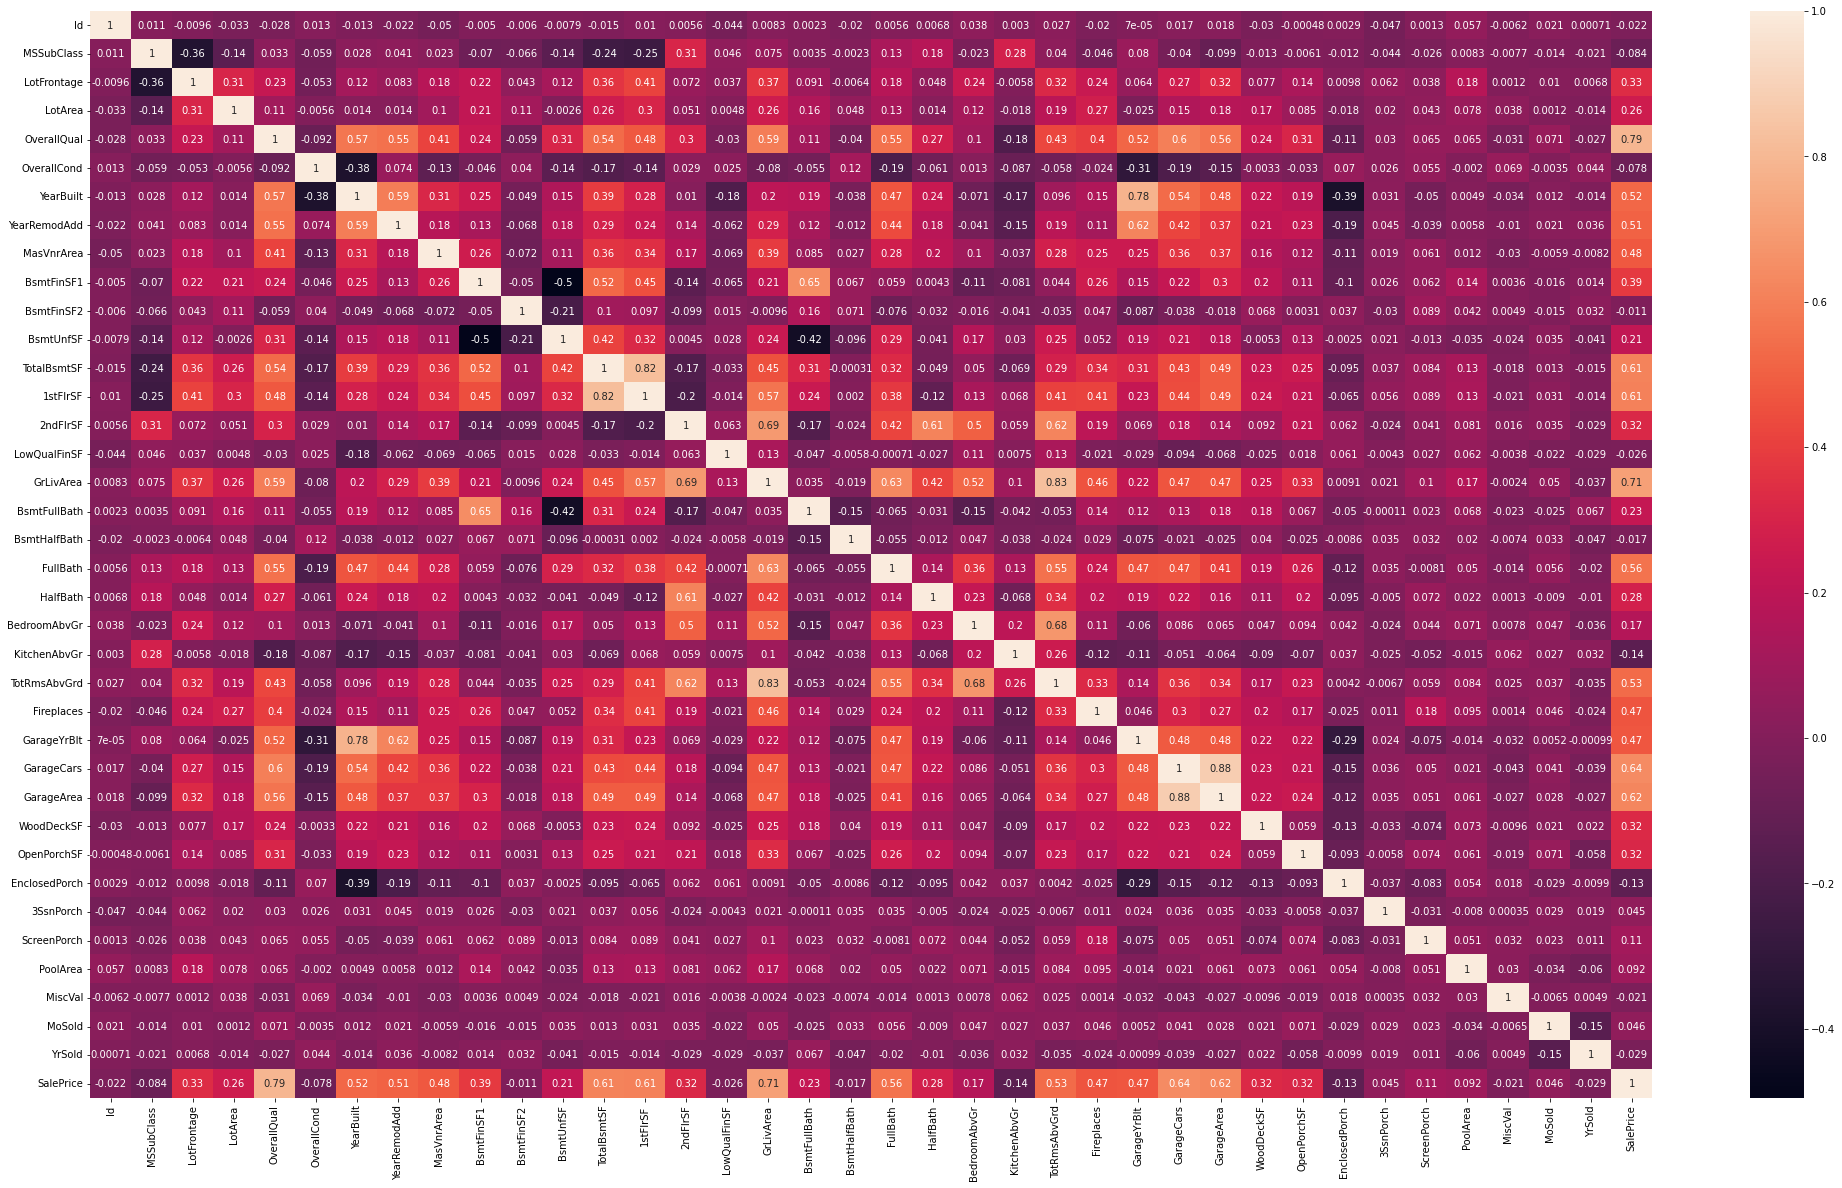

In [ ]:
plt.figure(figsize = (35,20))
sns.heatmap(train.corr(), annot=True)

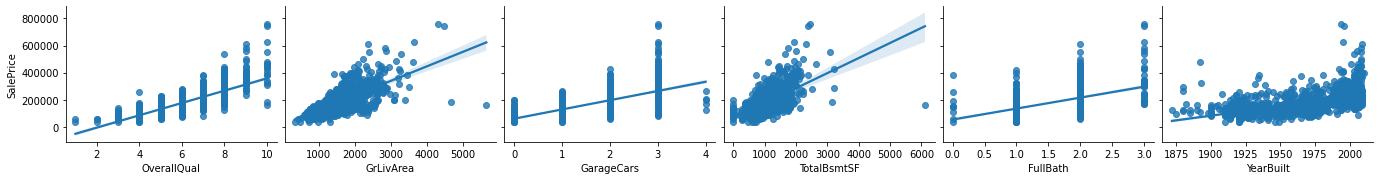

In [ ]:
features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train, y_vars='SalePrice', x_vars=features, kind='reg', height=2.5, aspect=1.3)

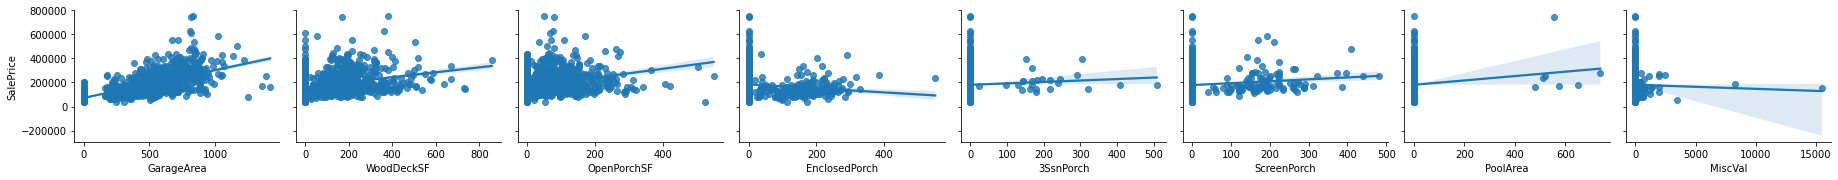

In [ ]:
features = ['GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
sns.pairplot(train, y_vars='SalePrice', x_vars=features, kind='reg', height=2.5, aspect=1.3)

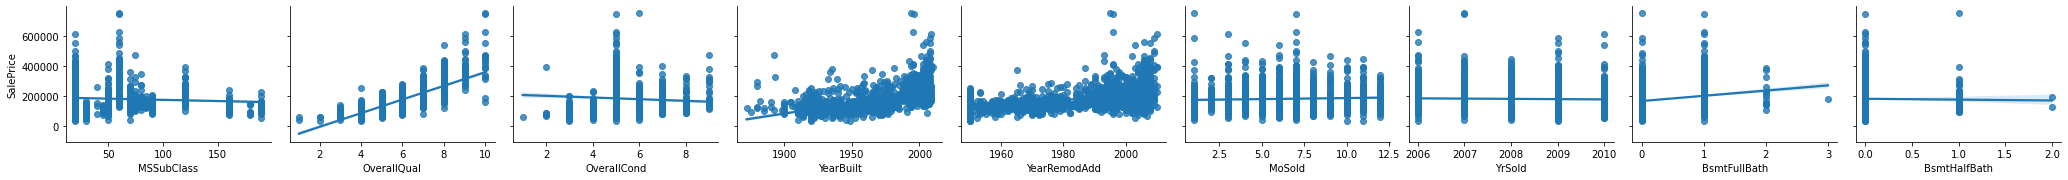

In [ ]:
features = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold', 'BsmtFullBath', 'BsmtHalfBath']
sns.pairplot(train, y_vars='SalePrice', x_vars=features, kind='reg', height=2.5, aspect=1.3)

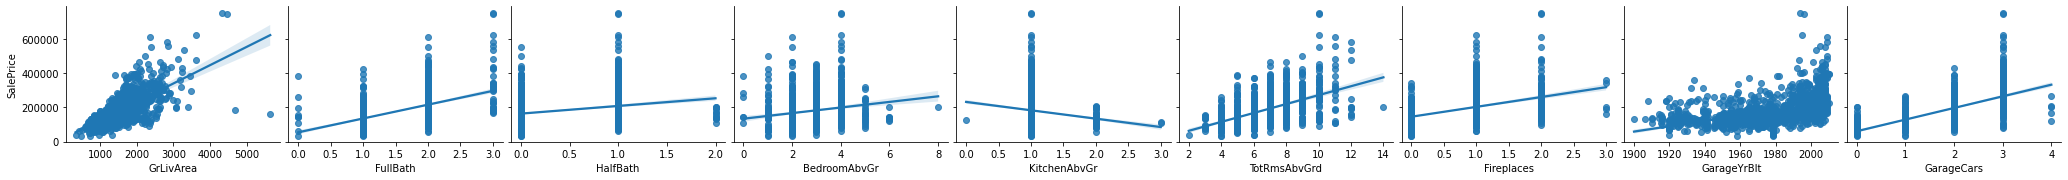

In [ ]:
features = ['GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars']
sns.pairplot(train, y_vars='SalePrice', x_vars=features, kind='reg', height=2.5, aspect=1.3)

In [ ]:
cols = []
cor_data = train.corr()
cor_lst = cor_data['SalePrice'].sort_values(ascending=False)
cor_lst = abs(cor_lst).sort_values(ascending=False)
for col in range(len(cor_lst)):
    if abs(cor_lst[col]) < 0.2:
        cols.append(cor_lst.index[col])
        
train.drop(cols,inplace=True, axis=1)
test.drop(cols, inplace=True, axis = 1)


In [ ]:
for feature in train.columns.values.tolist():
  if train[feature].dtype == object:
    train[feature] = train[feature].fillna(train[feature].mode()[0])
    test[feature] = test[feature].fillna(test[feature].mode()[0])

# Dummies handling
set dummies vals for categorical features

In [ ]:
  dummy_features_dict={'Has_Garage':'GarageArea','Has_Bsmt':'TotalBsmtSF','Has_2ndFlr':'2ndFlrSF','Has_Fireplace':'Fireplaces'}
  for dummy_ft in dummy_features_dict.keys():
    train[dummy_ft] = train[dummy_features_dict[dummy_ft]].apply(lambda x: 1 if x > 0 else 0)
    test[dummy_ft] = test[dummy_features_dict[dummy_ft]].apply(lambda x: 1 if x > 0 else 0)
  train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
  test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

# Label Encoding

In [ ]:
encoder = LabelEncoder()
for feature in train.columns.values.tolist():
  if train[feature].dtype == object:
    train[feature] = encoder.fit_transform(train[feature])
    test[feature] = encoder.fit_transform(test[feature])

# Training

In [ ]:
x = train.drop(['SalePrice'], axis=1)
y = train['SalePrice']
x_train, x_val, y_train, y_val =  train_test_split(x, y , test_size = 0.33, random_state= 42)

In [ ]:
lr = LinearRegression()   #LR
lr.fit(x_train, y_train)
ridge = RidgeCV()   #Ridge
ridge.fit(x_train, y_train)
lasso = LassoCV()   #Lasso
lasso.fit(x_train, y_train)
elastic = ElasticNetCV(l1_ratio=np.linspace(0.1, 1.0, 5))
elastic.fit(x_train, y_train)

ElasticNetCV(l1_ratio=array([0.1  , 0.325, 0.55 , 0.775, 1.   ]))

# Score Per model

In [ ]:
def print_model_results(model_name, model):
  print("{}:".format(model_name))
  print("train_score:", model.score(x_train,y_train))
  print("test_score:", model.score(x_val,y_val))
  print("train RMSE:", np.sqrt(mean_squared_error(np.log(y_train),np.log(model.predict(x_train)))))
  print("test RMSE:", np.sqrt(mean_squared_error(np.log(y_val),np.log(model.predict(x_val)))))
  print("------------------------------")

print_model_results("LinearRegression", lr)
print_model_results("Ridge", ridge)
print_model_results("Lasso", lasso)
print_model_results("ElasticNet", elastic)

LinearRegression:
train_score: 0.8487996220502496
test_score: 0.8272496219094495
train RMSE: 0.15748095292941186
test RMSE: 0.21948850525293884
------------------------------
Ridge:
train_score: 0.8477630316805951
test_score: 0.8288258778589008
train RMSE: 0.1549427667605462
test RMSE: 0.1868487420060905
------------------------------
Lasso:
train_score: 0.6882126066089116
test_score: 0.7643480064896377
train RMSE: 0.19286769024022105
test RMSE: 0.1912946707541188
------------------------------
ElasticNet:
train_score: 0.6882126066089116
test_score: 0.7643480064896377
train RMSE: 0.19286769024022105
test RMSE: 0.1912946707541188
------------------------------


In [ ]:
models = [lr, ridge, lasso, elastic]
M = len(models)
splits = 10
kf = KFold(n_splits=splits, shuffle=True, random_state=42)
score = np.empty((M, splits))

for i in range(0, M):
    score[i, :] = cross_val_score(models[i], x_train, y_train, cv=kf)


In [ ]:
pred=models[index].predict(test)
submission = pd.DataFrame({'Id': ids_lst, 'SalePrice': pred })
submission.to_csv('submission.csv', index=False)

In [ ]:
max_score=max(score.mean(axis=1))
index=np.where(score.mean(axis=1)==max_score)[0][0]
print('Max - ',score.mean(axis=1))
print('Index - ',index)

Max -  [0.78024372 0.78353321 0.63815774 0.63815774]
Index -  1


# References
Stackoverflow
and kagggle notebooks from the competition that are relevant to the subjects studied in class.

# Convert to html

In [ ]:
!pip install nbconvert
!jupyter nbconvert --to html ID_209006535.ipynb

[NbConvertApp] Converting notebook ID_209006535.ipynb to html
[NbConvertApp] Writing 1359131 bytes to ID_209006535.html
